## II. Bakery Dataset

In [1]:
import os
import sys
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = ""

sys.path.append("../")
print(os.getcwd())

from choice_learn.basket_models import AleaCarta

/Users/michael.teboul/Documents/choice-learn-1/notebooks


In [2]:
from choice_learn.datasets.bakery import load_bakery


data = load_bakery()
print(data)
print(f"\nThe TripDataset 'data' contains {data.n_items} distinct items that appear in {data.n_samples} transactions carried out at {data.n_stores} point(s) of sale with {data.n_assortments} different assortments.")

TripDataset with 75000 trips

The TripDataset 'data' contains 50 distinct items that appear in 266209 transactions carried out at 1 point(s) of sale with 1 different assortments.


II.1 AleaCarta model

In [12]:
latent_sizes = {"preferences": 6, "price": 3, "season": 3}
n_negative_samples = 2
optimizer = "adam"
lr = 0.01
epochs = 15
# epochs = 1000
batch_size = 32



In [13]:
model = AleaCarta(
    # item_intercept=True,
    item_intercept=False,
    price_effects=False,
    seasonal_effects=False,
    latent_sizes=latent_sizes,
    n_negative_samples=n_negative_samples,
    optimizer=optimizer,
    lr=lr,
    epochs=epochs,
    batch_size=batch_size,
)

model.instantiate(n_items=data.n_items, n_stores=data.n_stores)

In [14]:
history = model.fit(trip_dataset=data[:2000], verbose=1)#, val_dataset=data[70000:71000])

Epoch 14 Train Loss 0.8300: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


In [15]:
print(model.evaluate(trip_dataset=data[:1000]))


3.275692254143792


/var/folders/4n/g7n4s25944s77p645cqllzgh0000gp/T/ipykernel_83239/4062289676.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


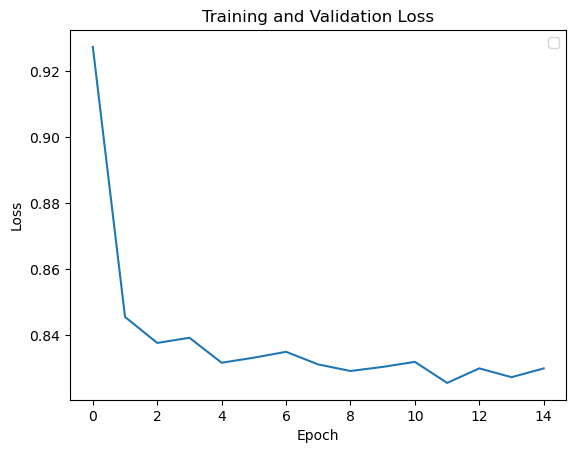

In [16]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")



plt.show()

In [17]:
import numpy as np

n_item = 50

n_comparaison = 50


item_batch = np.array(np.concatenate([[i]*n_comparaison for i in range(n_comparaison)]))
print('item_batch', item_batch)
basket_batch = np.concatenate([(np.arange(n_comparaison).reshape(-1, 1)) for i in range(n_comparaison)])

#basket_batch = np.array(np.concatenate([(np.arange(51)) for i in range(51)]))
print('basket_batch', basket_batch)
batch_size = n_comparaison**2

print('batch_size', batch_size)

available_item_batch =  np.array([[1]*n_item]*batch_size) 
price_batch = np.array([[1.0]*batch_size])

store_batch = np.array([0]*batch_size)
week_batch = np.array([0]*batch_size)



item_batch [ 0  0  0 ... 49 49 49]
basket_batch [[ 0]
 [ 1]
 [ 2]
 ...
 [47]
 [48]
 [49]]
batch_size 2500


In [18]:
compute_batch_utility = model.compute_batch_utility(item_batch=item_batch, basket_batch=basket_batch, price_batch=price_batch, available_item_batch=available_item_batch, store_batch=store_batch, week_batch=week_batch)


<class 'numpy.ndarray'>
[11.85601215 12.52919707 11.69248523 11.85283309 11.71470047 12.65135439
 12.55964484 12.45504338 11.84105464 11.71585986 12.45147157 12.5086265
 12.49372653 11.71046739 12.09050851 12.37997907 12.94744353 12.00508245
 12.16552038 12.3764153  12.25996019 12.68549203 12.39094567 11.98121174
 12.43458557 11.84654516 12.73555022 12.41060398 11.6334236  12.09262841
 11.99714448 12.00938916 12.06110484 12.44674553 11.46582488 12.25391933
 12.39429356 11.98746936 12.18634444 11.94613847 12.13027418 12.40339136
 11.87784777 12.4756055  12.08168789 12.13751563 11.43504917 11.64397737
 12.81407689 12.78643821]


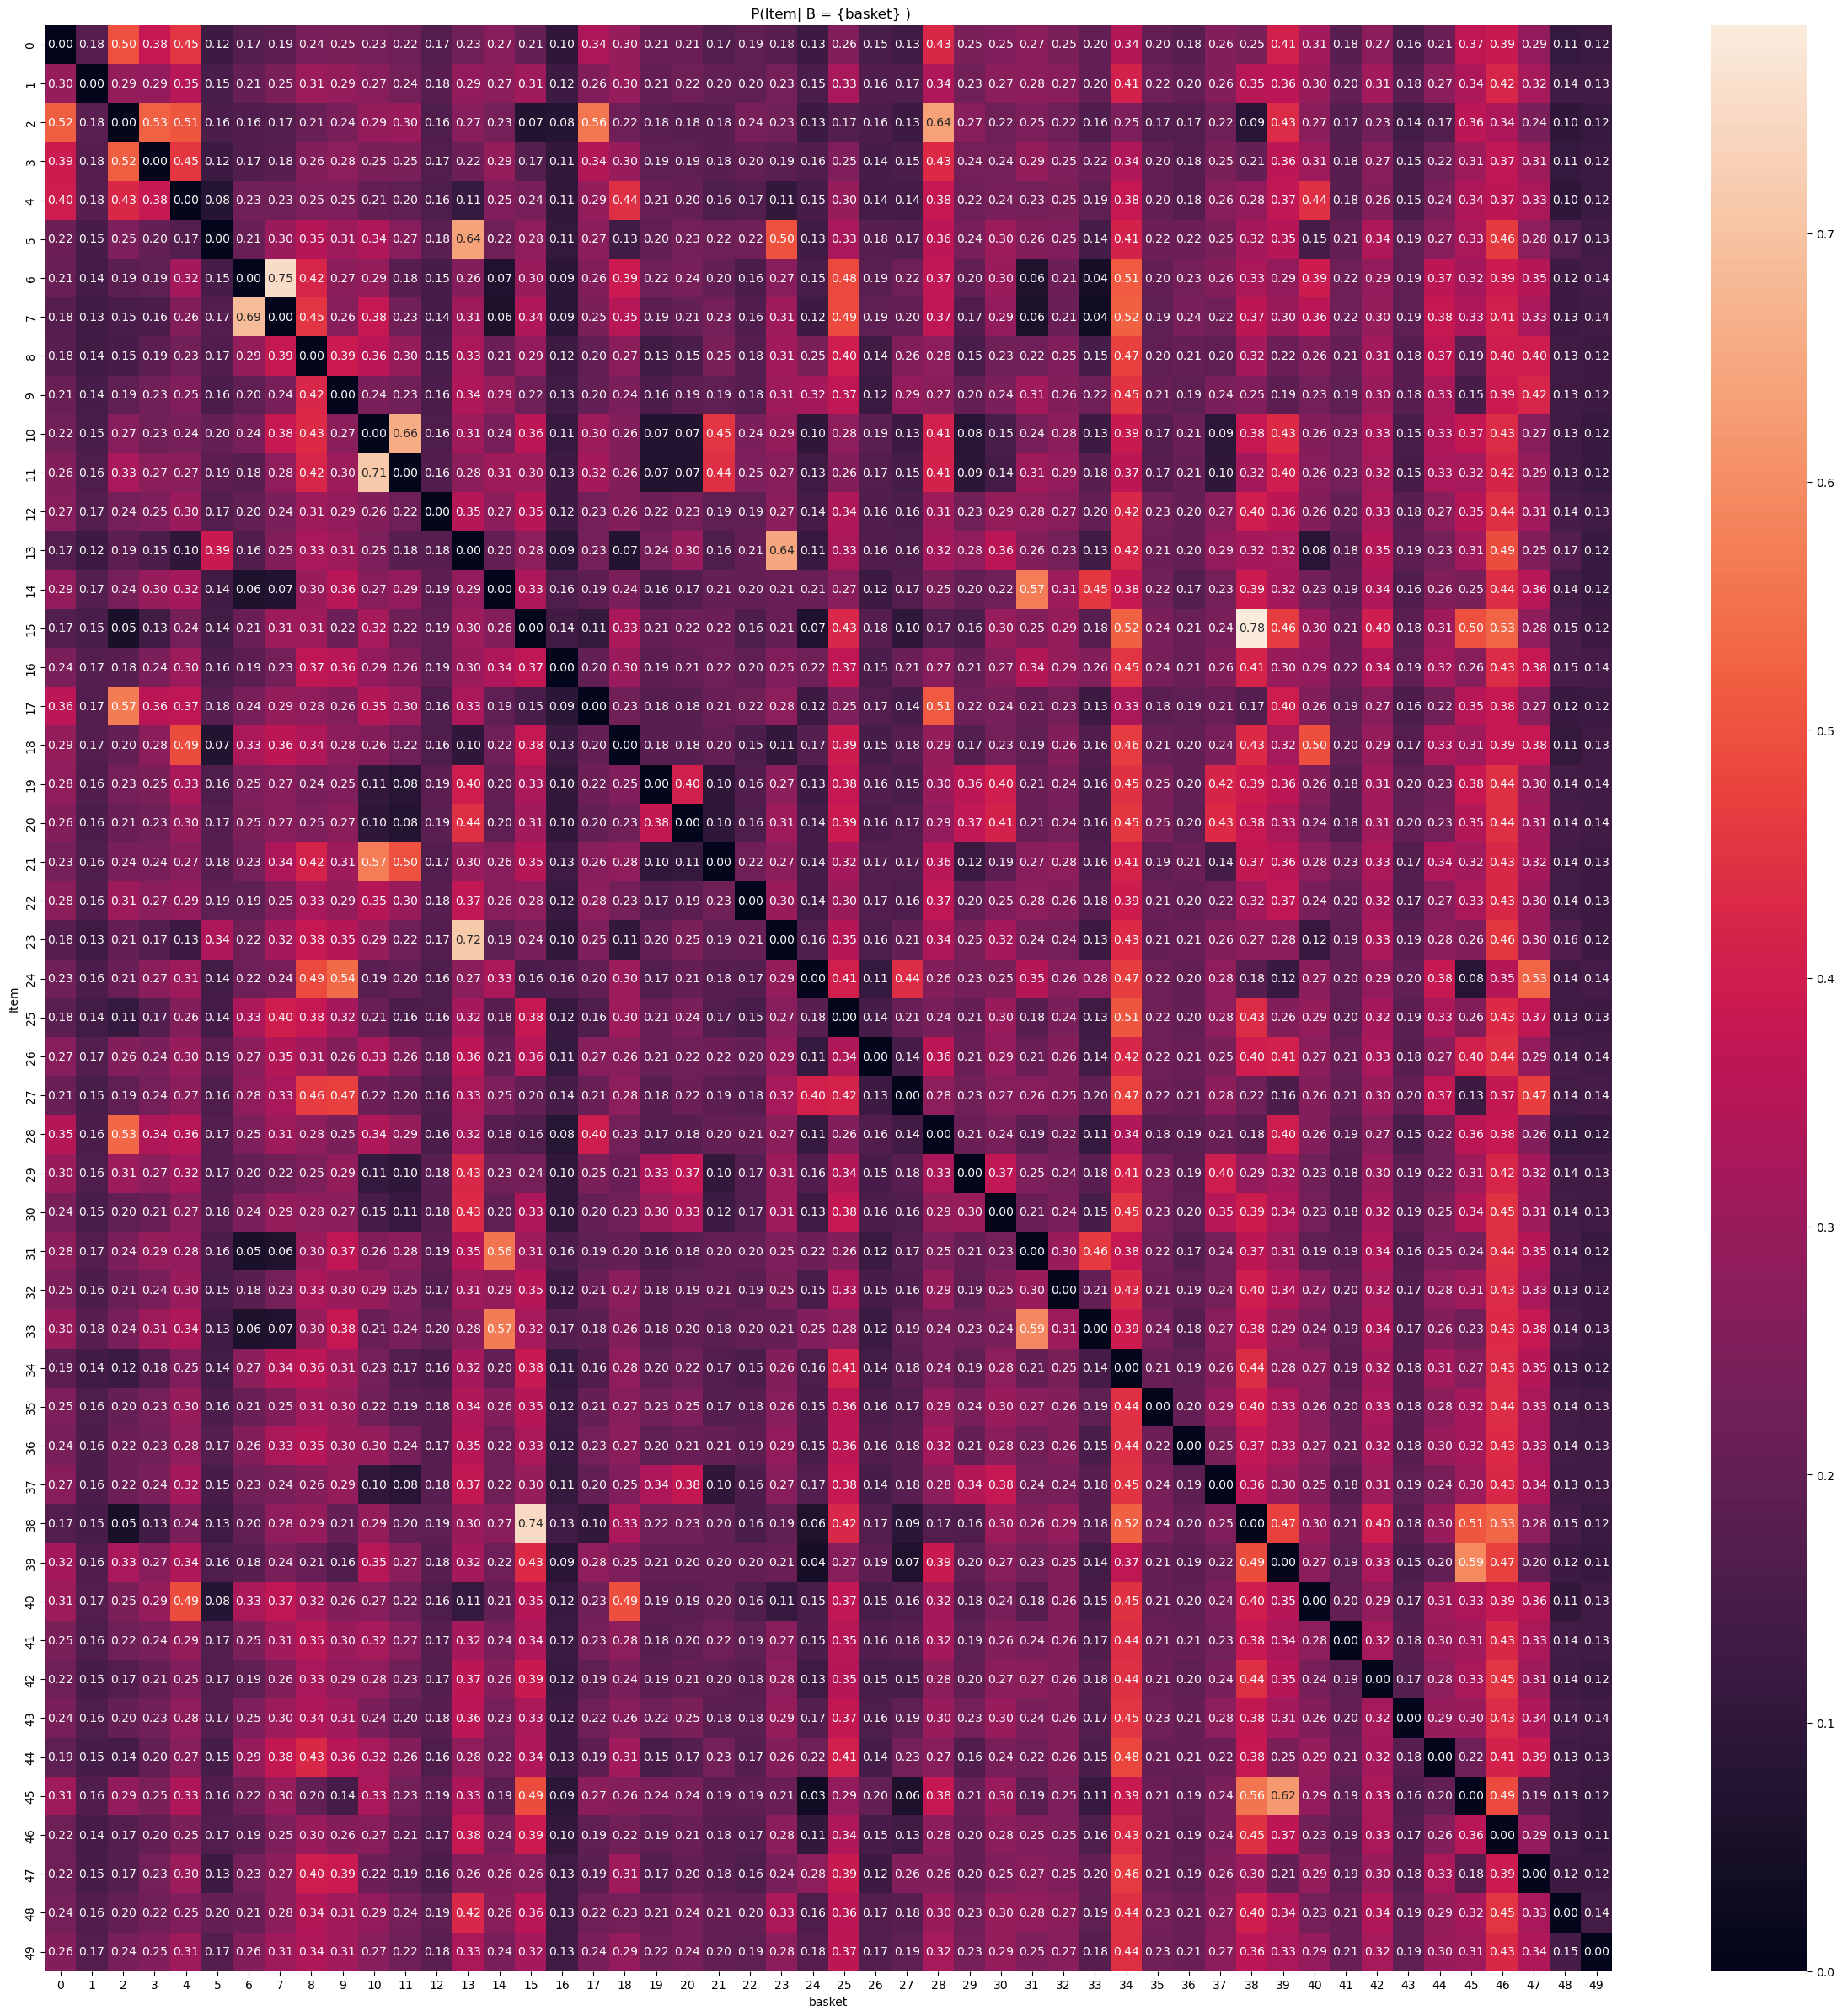

In [ ]:
import seaborn as sns
import math
matrix = np.zeros(shape = (n_item,n_comparaison))
print(type(matrix))
for i in range(n_comparaison):
    for j in range(n_comparaison):
        if i == j:
            matrix[i,j] = - math.inf
        else :
            matrix[i,j] = compute_batch_utility[i + j*n_comparaison]

for i in range(n_comparaison):
    sum = np.sum(np.exp(matrix[i,:]))
    for j in range(n_comparaison):
        matrix[i,j] = np.exp(matrix[i,j])/sum
        continue
    
#matrix = 1 / (1 + np.exp(-matrix))

print(np.sum(matrix, axis=1))
plt.figure(figsize=(30, 30))
sns.heatmap(matrix,
            annot=True,     
            fmt='.2f')
            #   ,cmap='viridis'   )   

plt.title(' P(Item| B = {basket} )') 
plt.ylabel('Item')   
plt.xlabel('basket')   
plt.show() 

II.2 (Test pour voir si la méthode prédict fonctionne)

II.3 Test des fonctions du notebook basic attention et affichage de la matrice de probas initiale

In [ ]:
import tensorflow as tf
def visualise_tripdataset_trips(dataset, n_items):
    """
    Visualize the conditional probability P(i|j) of items co-occurring in baskets.

    Parameters
    ----------
    dataset : TripDataset
        The dataset containing trips.
    n_items : int
        Number of unique items.
    """
    distribution_matrix = np.zeros((n_items, n_items))
    for trip in dataset.trips:
        basket = trip.purchases
        for i in basket:
            for j in basket:
                if i != j:
                    distribution_matrix[i, j] += 1
    row_sums = distribution_matrix.sum(axis=1, keepdims=True)
    for i in range(len(row_sums)):
        if row_sums[i] != 0:
            distribution_matrix[i] = distribution_matrix[i]/row_sums[i]
    
    return distribution_matrix


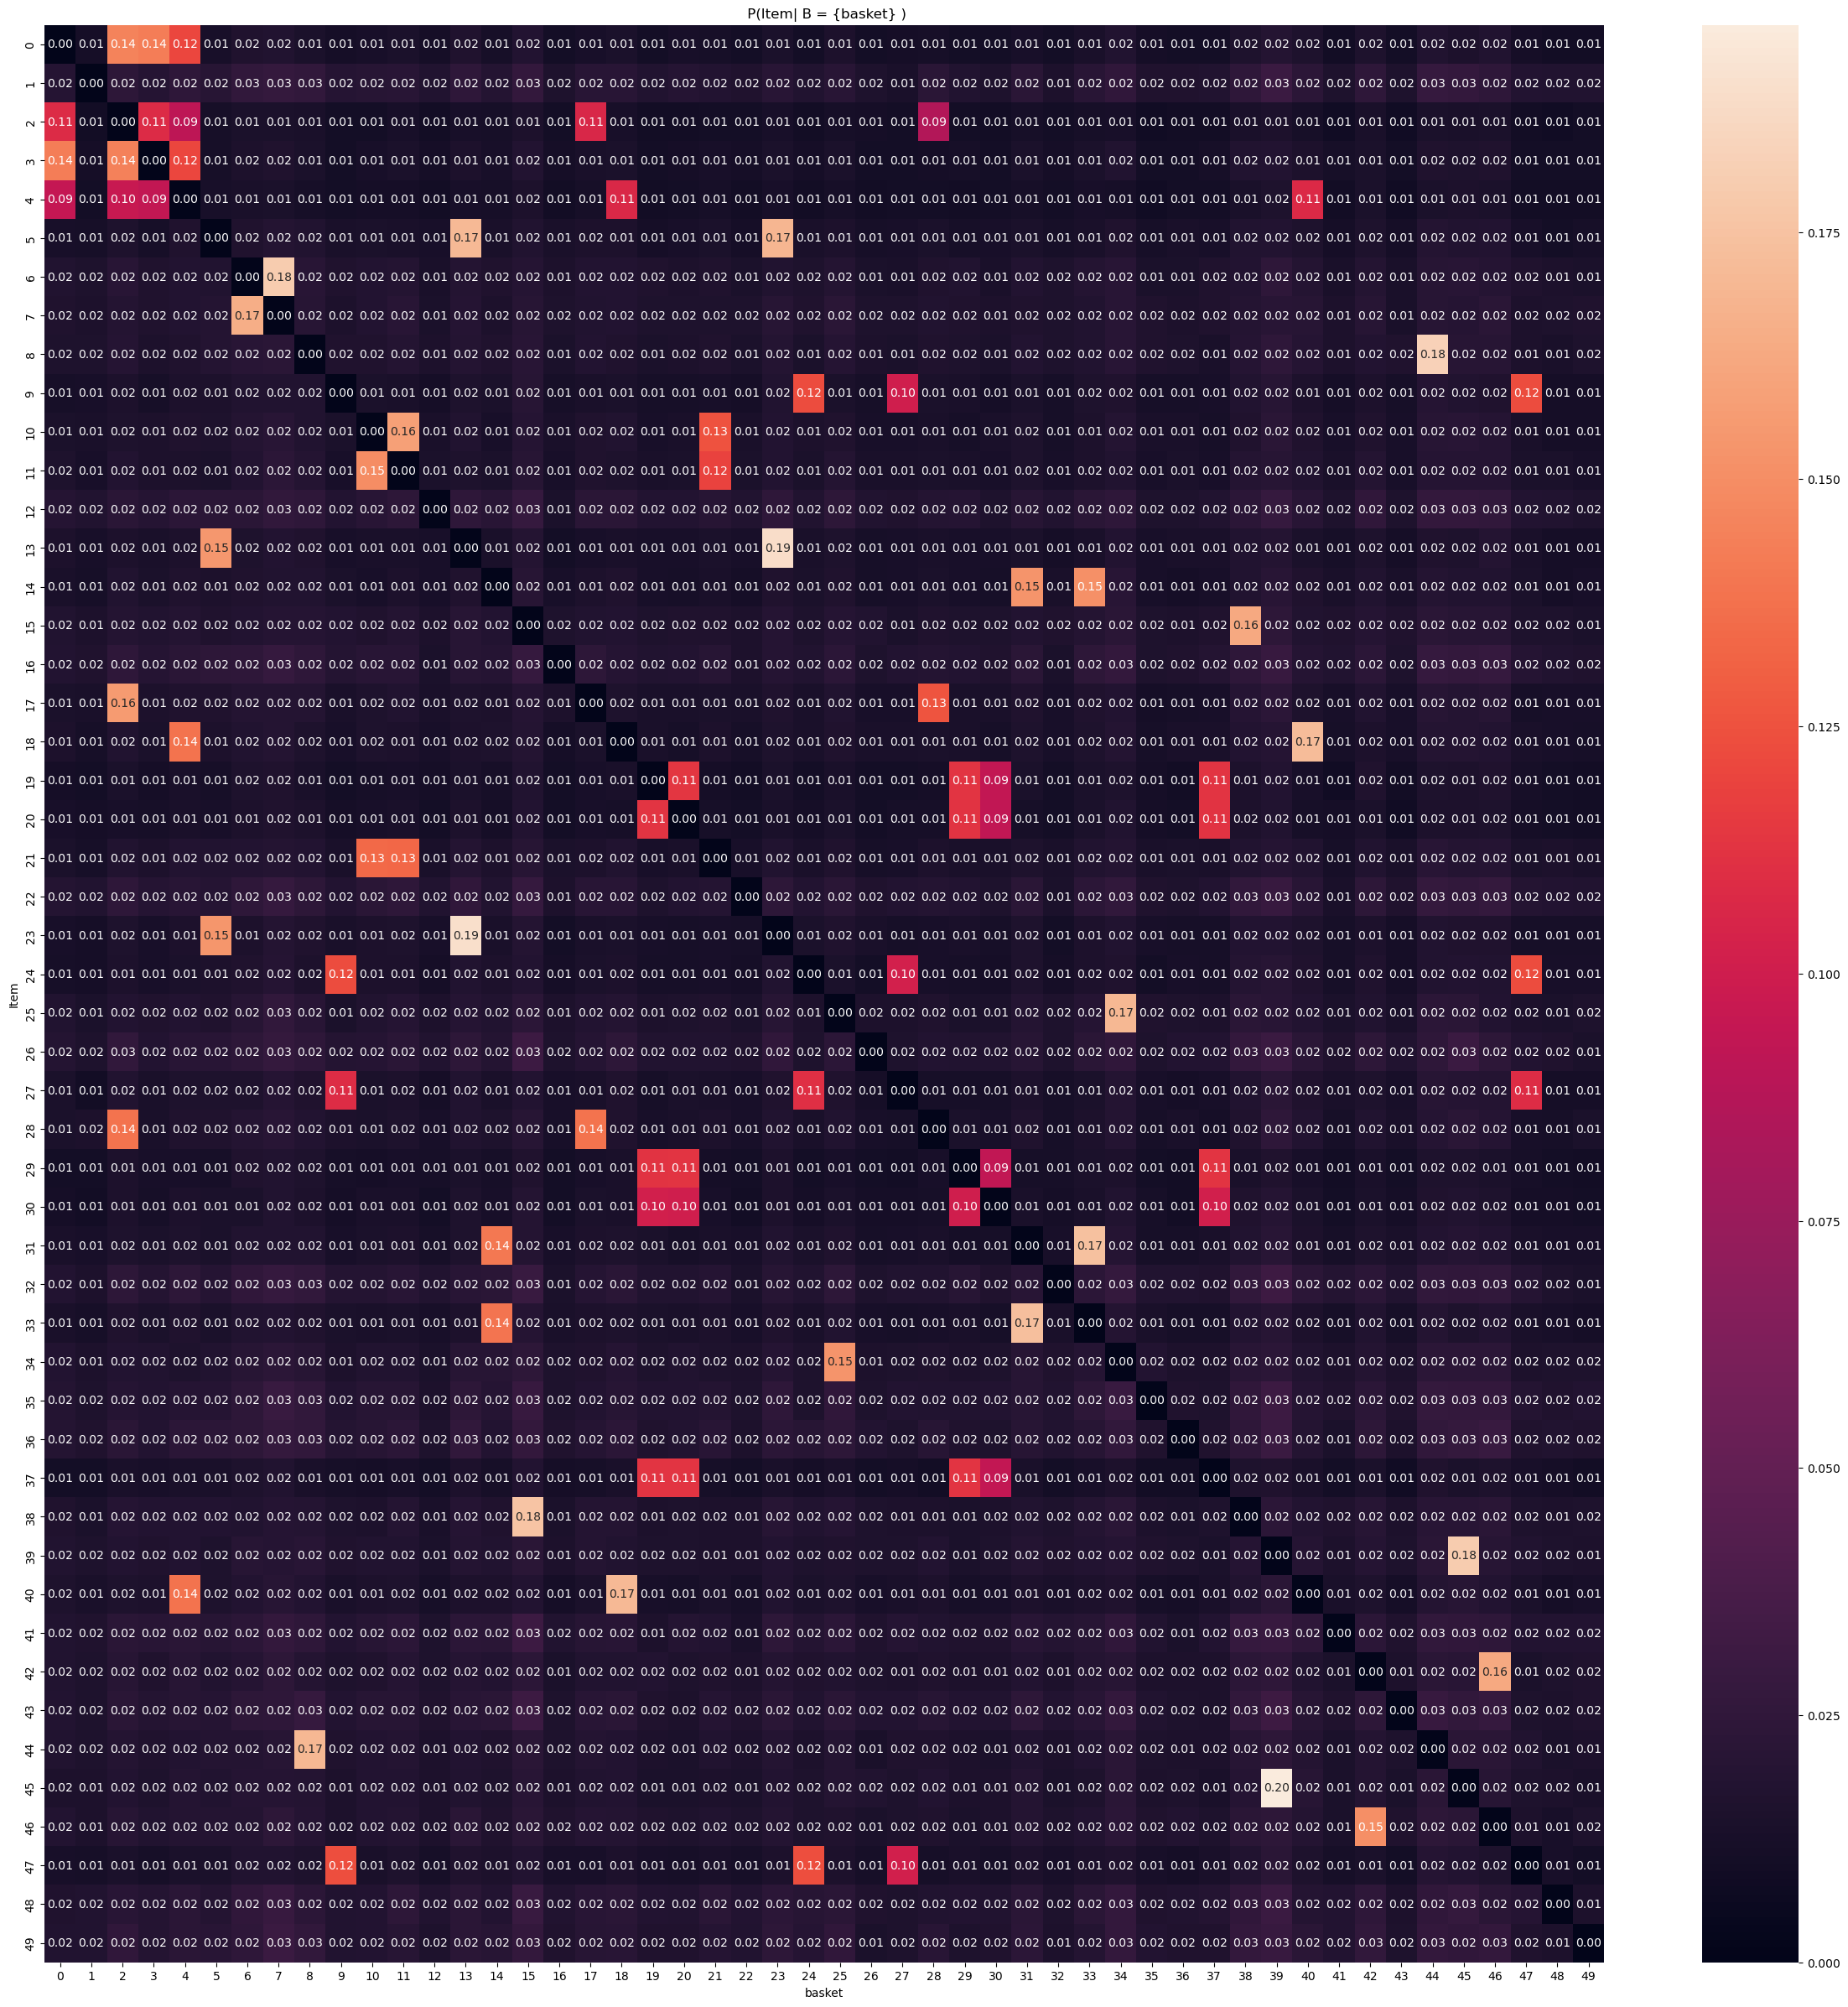

In [23]:
initial_cond_proba = visualise_tripdataset_trips(data, n_item)

plt.figure(figsize=(30, 30))
sns.heatmap(initial_cond_proba,
            annot=True,     
            fmt='.2f')
            #   ,cmap='viridis'   )   

plt.title(' P(Item| B = {basket} )') 
plt.ylabel('Item')   
plt.xlabel('basket')   
plt.show() 


II.4 Basic-Attention Model

In [50]:
from choice_learn.basket_models.basic_attention_model import AttentionBasedContextEmbedding

epochs = 6

model2 = AttentionBasedContextEmbedding(
    n_negative_samples=n_negative_samples,
    optimizer=optimizer,
    lr=lr,
    epochs=epochs,
    batch_size=batch_size,
)

model2.instantiate(n_items=data.n_items)



In [ ]:
history2 = model2.fit(trip_dataset=data[:66000], verbose=1, val_dataset=data[66000:67000])#, val_dataset=data[2000:3000])

plt.plot(history2["train_loss"])
plt.plot(history2["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")



plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
print(model2.evaluate(trip_dataset=data[:1000]))
#model.evaluate(trip_dataset=data[50000:51000])

3.467426585472834


In [ ]:
import numpy as np

n_item = 50

n_comparaison = 50


item_batch = np.array(np.concatenate([[i]*n_comparaison for i in range(n_comparaison)]))
print('item_batch', item_batch)
basket_batch = np.concatenate([(np.arange(n_comparaison).reshape(-1, 1)) for i in range(n_comparaison)])

#basket_batch = np.array(np.concatenate([(np.arange(51)) for i in range(51)]))
print('basket_batch', basket_batch)
batch_size = n_comparaison**2

print('batch_size', batch_size)

available_item_batch =  np.array([[1]*n_item]*batch_size) 
price_batch = np.array([[1.0]*batch_size])

store_batch = np.array([0]*batch_size)
week_batch = np.array([0]*batch_size)


item_batch [ 0  0  0 ... 49 49 49]
basket_batch [[ 0]
 [ 1]
 [ 2]
 ...
 [47]
 [48]
 [49]]
batch_size 2500


In [ ]:
compute_batch_utility = model2.compute_batch_utility(item_batch=item_batch, basket_batch=basket_batch, price_batch=price_batch, available_item_batch=available_item_batch, store_batch=store_batch, week_batch=week_batch)


[1.52892452 1.0766182  1.10809522 1.49931145 1.95232917 1.51707643
 0.88382205 1.24167024 1.2248567  1.25195336 1.1910225  1.29380023
 1.12341637 1.38930751 1.10040755 1.12442039 1.05229242 1.00493193
 1.17606058 1.09420309 1.35284636 1.26376109 1.0803847  1.198282
 1.18418376 1.09317424 1.1043713  1.13635548 1.14520166 1.08993252
 1.62792378 1.31189203 1.12371861 0.96915932 1.2249624  1.04197501
 1.0961166  1.14284076 1.08798467 1.26815775 1.2966778  1.09689168
 1.05190385 1.1124977  1.41739189 1.08383039 1.13360797 1.3457895
 1.10247589 1.01554281]


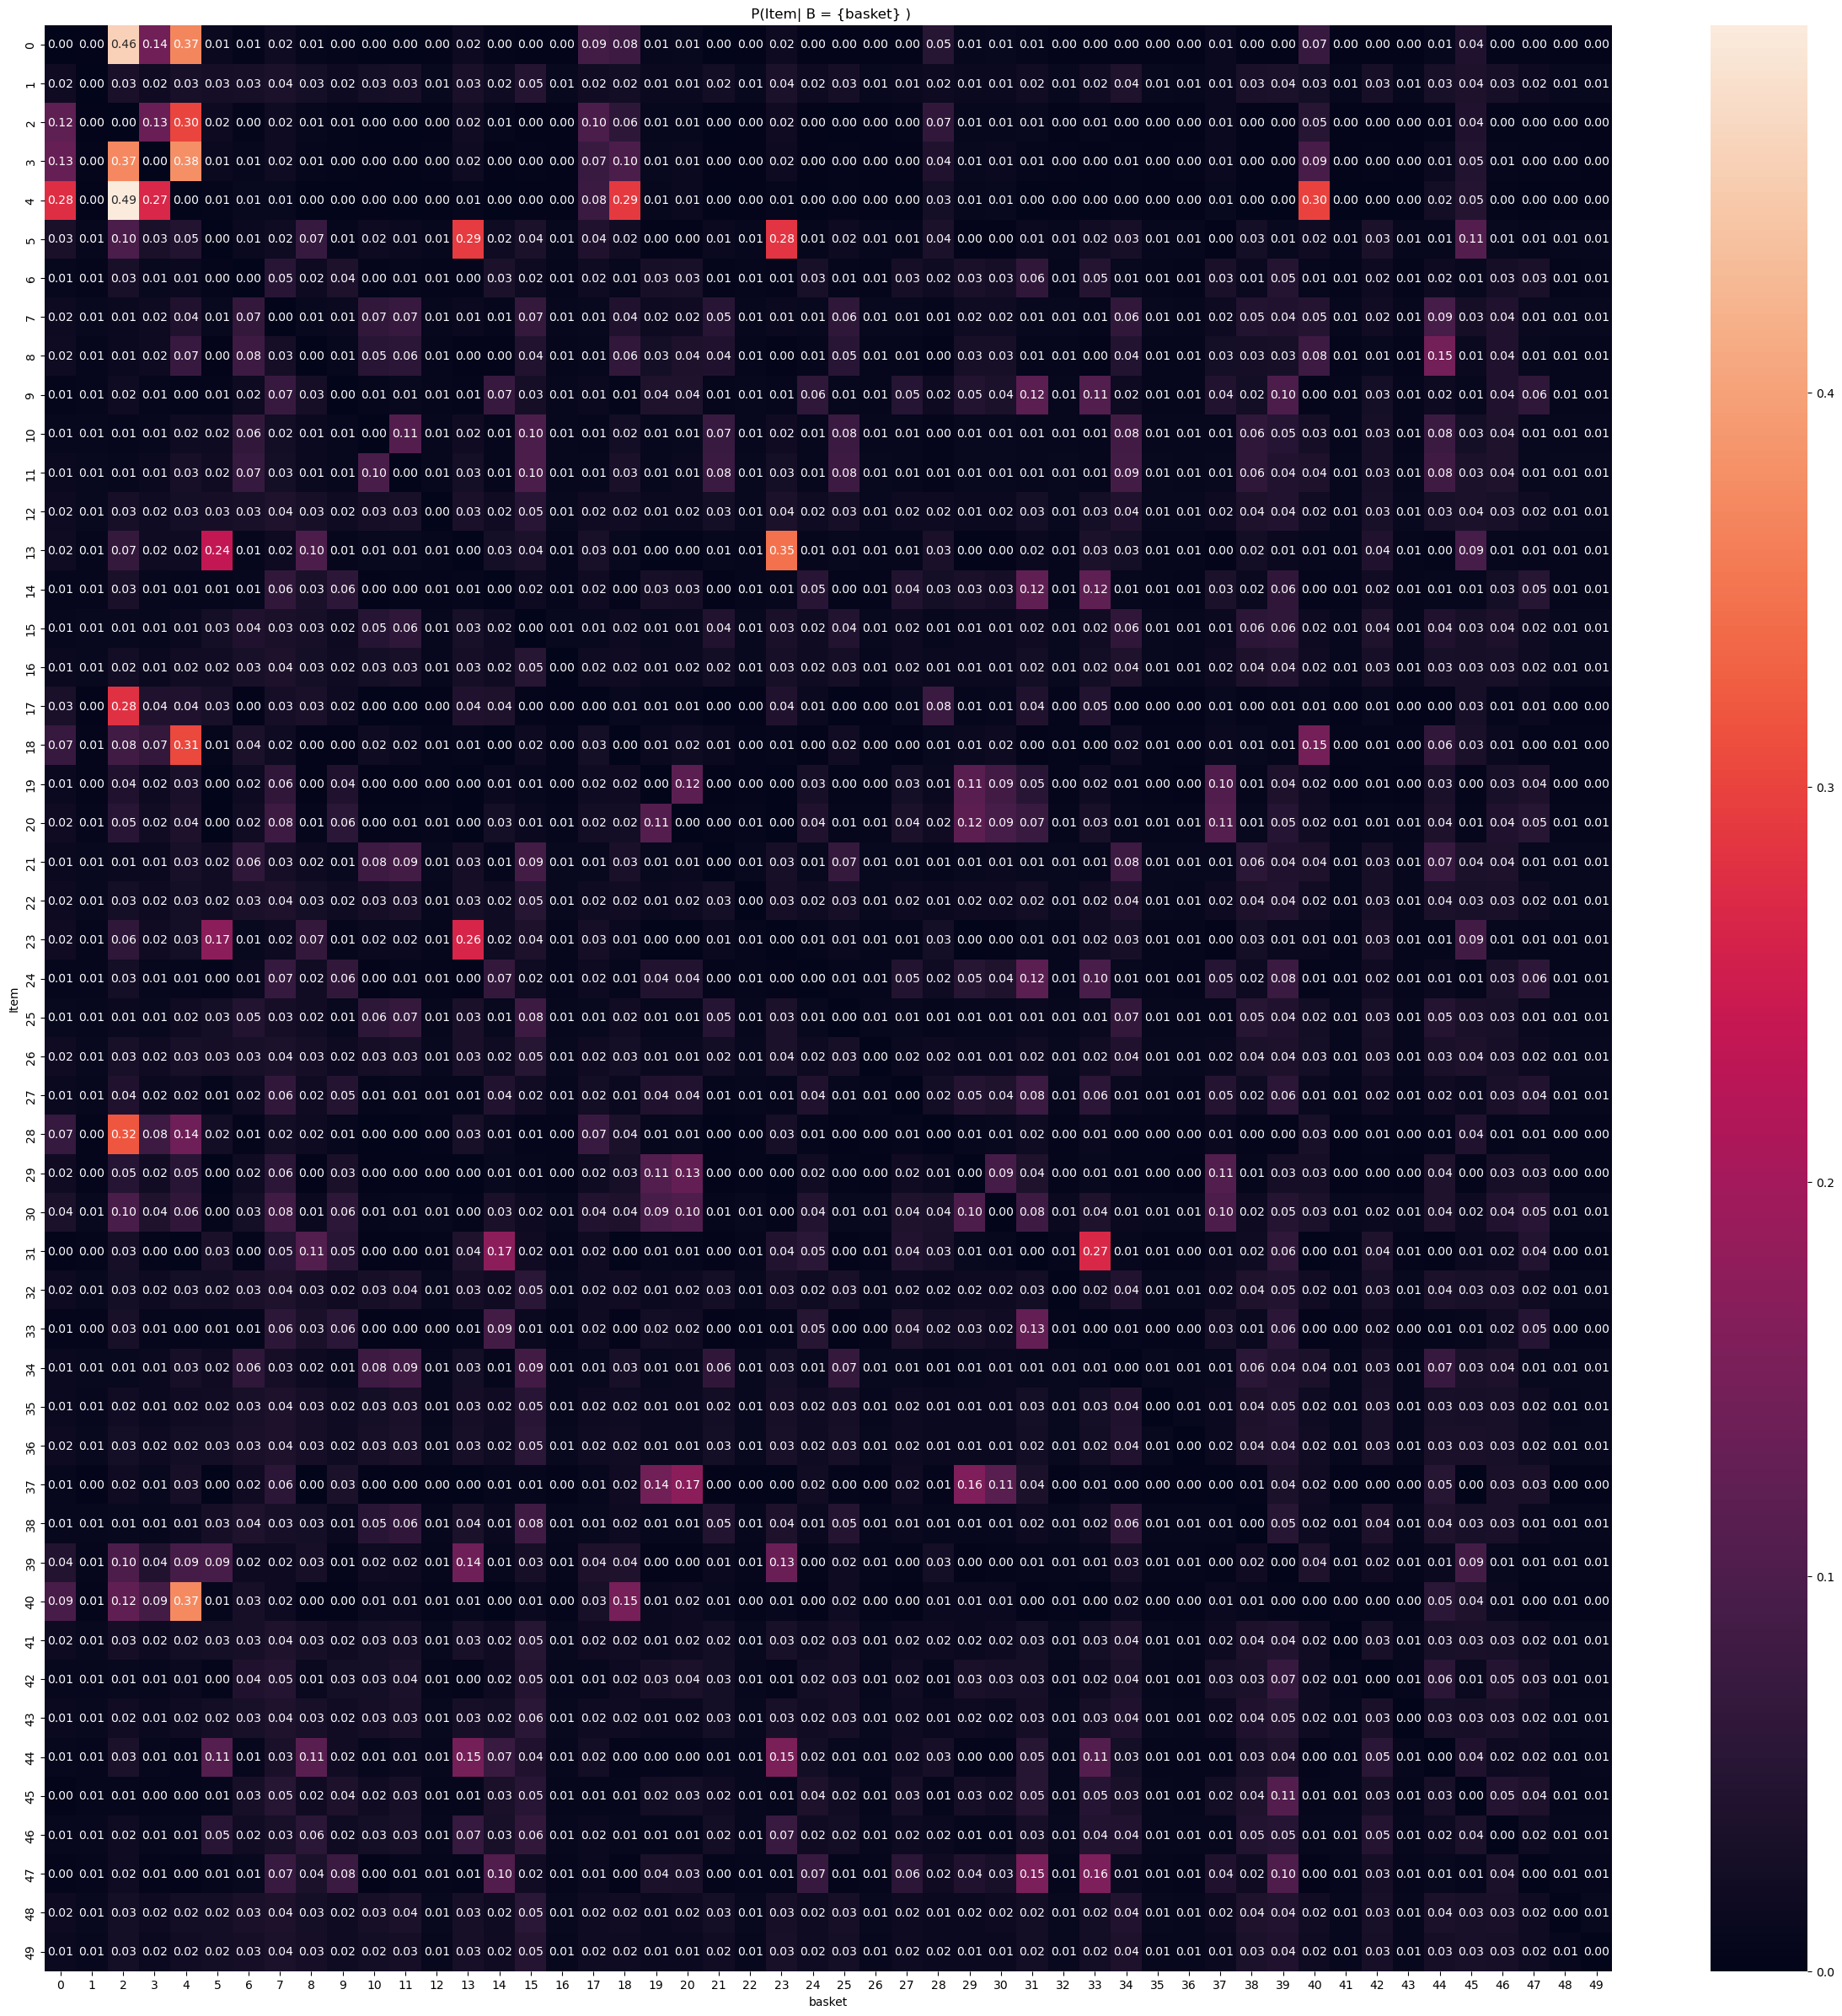

In [ ]:
import seaborn as sns
import math
matrix = np.zeros(shape = (n_comparaison,n_comparaison))

for i in range(n_comparaison):
    for j in range(n_comparaison):
        if i == j:
            matrix[i,j] = - math.inf
        else :
            matrix[i,j] = compute_batch_utility[i + j*n_comparaison]

for i in range(n_comparaison):
    sum = np.sum(np.exp(matrix[i,:]))
    for j in range(n_comparaison):
        matrix[i,j] = np.exp(matrix[i,j])/sum
        continue
    
#matrix = 1 / (1 + np.exp(-matrix))

print(np.sum(matrix, axis=1))
plt.figure(figsize=(30, 30))
sns.heatmap(matrix,
            annot=True,     
            fmt='.2f')
            #   ,cmap='viridis'   )   

plt.title(' P(Item| B = {basket} )') 
plt.ylabel('Item')   
plt.xlabel('basket')   
plt.show() 